# Modelado de Clasificación de Tumores Cerebrales en Imágenes MRI usando CNN
En este notebook se desarrolla el proceso completo de modelado, entrenamiento y evaluación de una red neuronal convolucional (CNN) para clasificar imágenes MRI preprocesadas en tres tipos de tumores: glioma, meningioma y tumor genérico.

In [1]:
# 1. Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


Total de imágenes cargadas: 6056
Dimensiones de las imágenes: (128, 128) (esperado: (128, 128))
Distribución de clases: [2004 2004 2048]


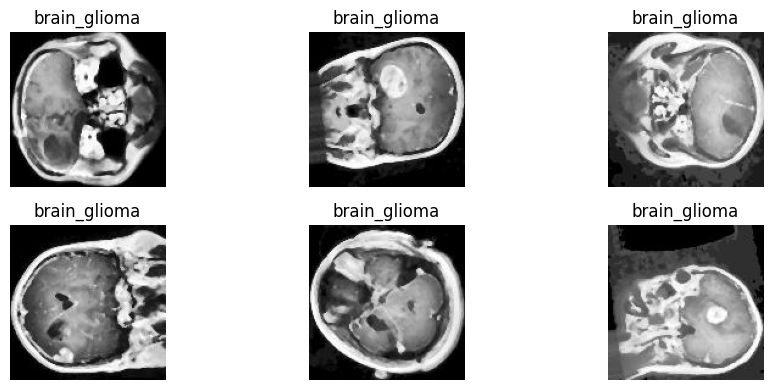

In [ ]:
# 2. Cargar y explorar los datos preprocesados

def cargar_datos_preprocesados(ruta_base, clases, img_size=(128, 128)):
    X, y = [], []
    for idx, clase in enumerate(clases):
        ruta_clase = os.path.join(ruta_base, clase)
        for nombre_img in os.listdir(ruta_clase):
            ruta_img = os.path.join(ruta_clase, nombre_img)
            try:
                img = Image.open(ruta_img).convert('L')  # Asumimos imágenes en escala de grises
                img = img.resize(img_size)
                X.append(np.array(img))
                y.append(idx)
            except Exception as e:
                print(f"Error cargando {ruta_img}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y

# Definir rutas y clases
RUTA_PREPROCESADAS = '../data/preprocesadas'
CLASES = ['brain_glioma', 'brain_menin', 'brain_tumor']
IMG_SIZE = (128, 128)

# Cargar datos
X, y = cargar_datos_preprocesados(RUTA_PREPROCESADAS, CLASES, IMG_SIZE)
print(f"Total de imágenes cargadas: {X.shape[0]}")
print(f"Dimensiones de las imágenes: {X.shape[1:]} (esperado: {IMG_SIZE})")
print(f"Distribución de clases: {np.bincount(y)}")

# Visualizar algunas imágenes
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(CLASES[y[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
# 3. Dividir los datos en train, validación y test, y preparar para la CNN

# Normalizar y expandir dimensiones para CNN (canal único)
X = X.astype('float32') / 255.0
X = np.expand_dims(X, axis=-1)

y_cat = to_categorical(y, num_classes=len(CLASES))

# División: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 4239, Val: 908, Test: 909


In [4]:
# 4. Construir la arquitectura de la CNN

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(CLASES), activation='softmax')
])

model.summary()

d:\Proyectos_programación\mriTumorClassifier\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3879 - loss: 1.1949 - val_accuracy: 0.6729 - val_loss: 0.8253
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3879 - loss: 1.1949 - val_accuracy: 0.6729 - val_loss: 0.8253
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6393 - loss: 0.8082 - val_accuracy: 0.6311 - val_loss: 0.7952
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6393 - loss: 0.8082 - val_accuracy: 0.6311 - val_loss: 0.7952
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.6906 - loss: 0.7206 - val_accuracy: 0.7665 - val_loss: 0.5699
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.6906 - loss: 0.7206 - val_accuracy: 0.7665 - val_loss: 0.5699
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.7135 - loss: 0.6547 - val_accuracy: 0.7808 - val_loss: 0.5279
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.7135 - loss: 0

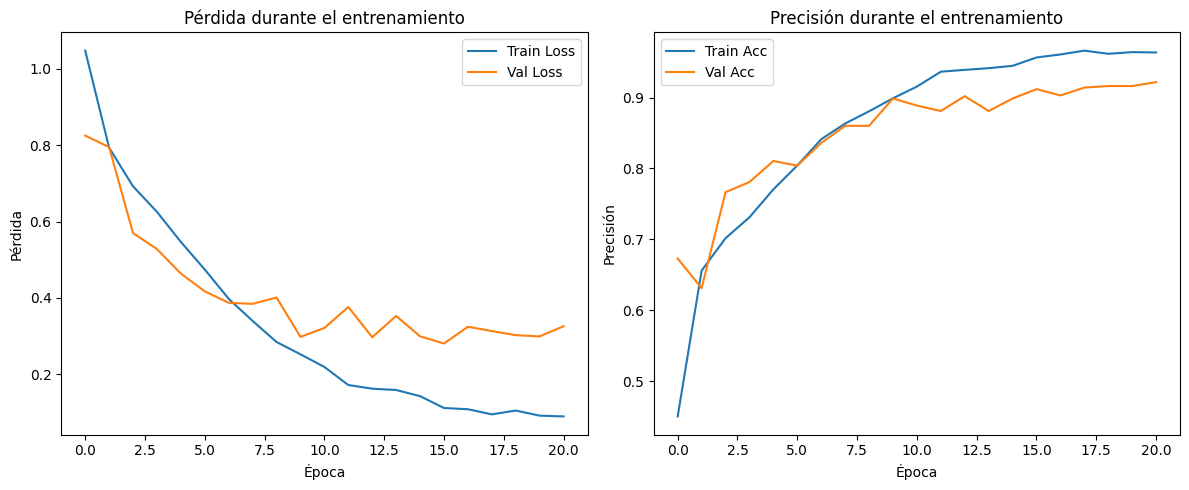

In [5]:
# 5. Compilar y entrenar el modelo

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Visualizar historia de entrenamiento
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
# 6. Guardar el modelo entrenado con timestamp
import datetime

MODELOS_DIR = '../models'
os.makedirs(MODELOS_DIR, exist_ok=True)

fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
nombre_modelo = f"cnn_mri_{fecha_hora}.h5"
ruta_modelo = os.path.join(MODELOS_DIR, nombre_modelo)

model.save(ruta_modelo)
print(f"Modelo guardado en: {ruta_modelo}")

Modelo guardado en: ../models\cnn_mri_20250703_102034.h5
